In this notebook I am only interested in plotting basic data agregated by countries for the main occidental countries.

In [1]:
import sys
from IPython.display import display

sys.path.append('../')

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

%matplotlib inline

In [3]:
from definitions import DATA_DIR, ROOT_DIR
from covid.data_download import download_data_from_kaggle
from covid.plotting import plot_by_country
from covid.processing import get_start_date, filter_by_trigger_date

In [4]:
download_data_from_kaggle()
downloaded_files = list((ROOT_DIR / DATA_DIR).glob('*.csv'))

print(f"Downloaded files:\n{chr(10).join(str(f.name) for f in downloaded_files)}")

covid19-global-forecasting-week-1.zip: Skipping, found more recently modified local copy (use --force to force download)
Downloaded files:
test.csv
train.csv
submission.csv


In [5]:
data_dir = ROOT_DIR / DATA_DIR
file_train = data_dir / 'train.csv'
file_test = data_dir / 'test.csv'

In [6]:
data_train = pd.read_csv(file_train, parse_dates=['Date'])
data_train.sample(10)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
2244,3361,Grand Princess,Canada,37.6489,-122.6655,2020-02-03,0.0,0.0
12987,19467,NaN,The Gambia,13.4667,-16.6000,2020-02-20,0.0,0.0
17258,25877,United Kingdom,United Kingdom,55.3781,-3.4360,2020-02-13,9.0,0.0
17013,25508,Cayman Islands,United Kingdom,19.3133,-81.2546,2020-02-16,0.0,0.0
1531,2276,NaN,Benin,9.3077,2.3158,2020-03-05,0.0,0.0
12720,19076,NaN,Taiwan*,23.7000,121.0000,2020-02-01,10.0,0.0
3378,5053,Guizhou,China,26.8154,106.8748,2020-02-21,146.0,2.0
4297,6437,Qinghai,China,35.7452,95.9956,2020-02-10,18.0,0.0
9565,14340,NaN,Mauritania,21.0079,10.9408,2020-02-08,0.0,0.0
16795,25166,Wisconsin,US,44.2685,-89.6165,2020-03-17,72.0,0.0


I will drop the `Province/State`, `Lat`, `Long`.
For countries with a mainland and other territories (France and United Kingdom), I will keep the mainland. In the future, I may select some States form the USA.

In [7]:
rename_dict = {'Province/State': 'state', 'Country/Region': 'country', 'ConfirmedCases': 'cases', 'Fatalities': 'deaths'}
data_train = data_train.rename(columns=rename_dict).rename(columns=lambda x: x.lower())

data_train.columns

Index(['id', 'state', 'country', 'lat', 'long', 'date', 'cases', 'deaths'], dtype='object')

In [8]:
country_list = ['France', 'Italy', 'Germany', 'Sweden', 'United Kingdom', 'Norway', 'Spain']

data = data_train.loc[data_train.country.isin(country_list) & ((data_train.country == data_train.state) | data_train.state.isna())]

In [9]:
data = data.loc[:, ['country', 'date', 'cases', 'deaths']]

In [10]:
data = data.set_index('date')

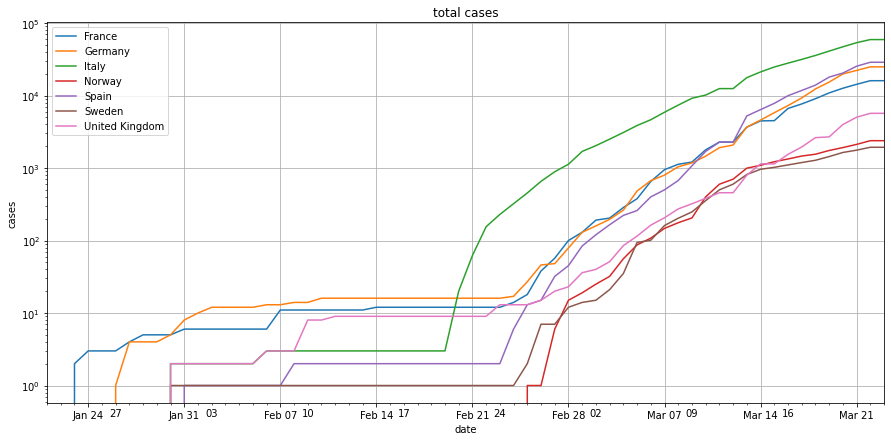

In [11]:
plot_by_country(data, 'cases', 'total cases', logy=True)

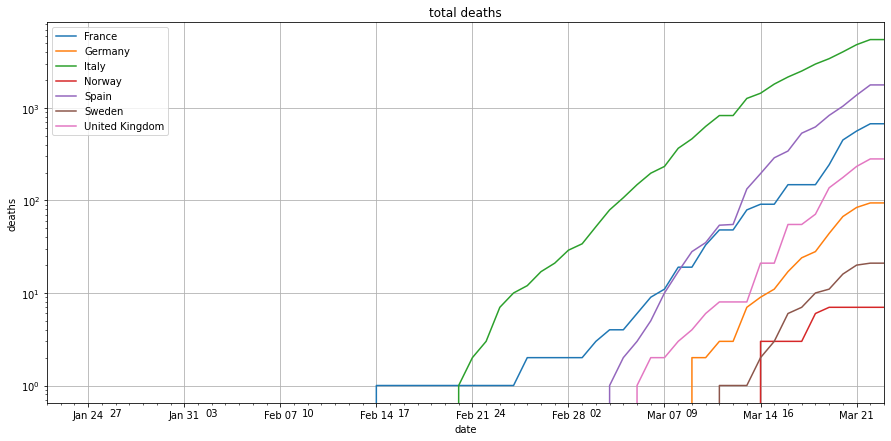

In [12]:
plot_by_country(data, 'deaths', 'total deaths', logy=True)

# Trigger date is when 100 cases are declared

In [13]:
threshold = 100
case_trigger = get_start_date(data, 'cases', threshold=threshold)
display(case_trigger)

country
France           2020-02-29
Germany          2020-03-01
Italy            2020-02-23
Norway           2020-03-06
Spain            2020-03-02
Sweden           2020-03-06
United Kingdom   2020-03-05
Name: cases_trigger_date, dtype: datetime64[ns]

### lags between countries

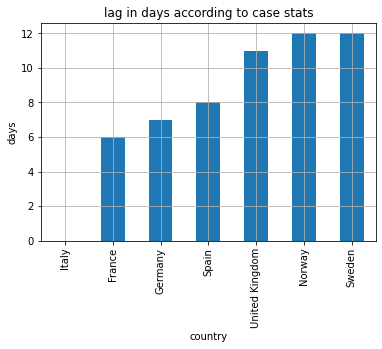

In [14]:
case_lags = case_trigger.apply(lambda x: x - case_trigger.min())
ax = case_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, title='lag in days according to case stats')
ax.set(ylabel='days')
plt.show()

In [15]:
case_offset_data = filter_by_trigger_date(data, 'cases', threshold=threshold)
case_offset_data

,country,cases,deaths
date,,,
0 days,France,100.0,2.0
1 days,France,130.0,2.0
2 days,France,191.0,3.0
3 days,France,204.0,4.0
4 days,France,285.0,4.0
...,...,...,...
14 days,United Kingdom,2689.0,137.0
15 days,United Kingdom,3983.0,177.0
16 days,United Kingdom,5018.0,233.0


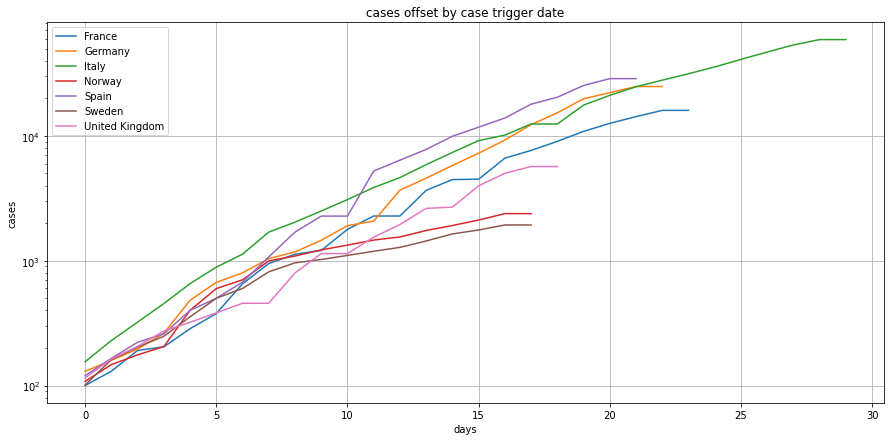

In [16]:
ax = plot_by_country(case_offset_data, 'cases', title='cases offset by case trigger date', logy=True)

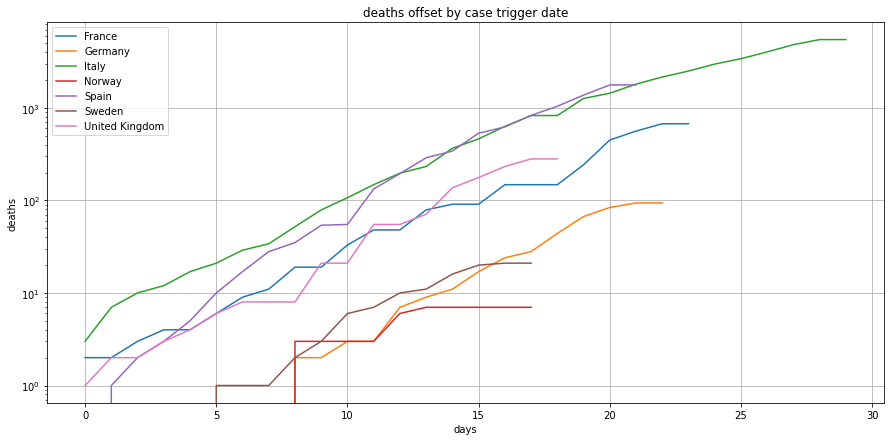

In [17]:
plot_by_country(case_offset_data, 'deaths', title='deaths offset by case trigger date', logy=True)

# Trigger date is when 5 deaths are declared
(5 because for the moment Norway has a maximum of 7 deaths in the dataset)

In [18]:
((case_offset_data.index / pd.Timedelta(1, 'd')).astype(int)).name = 'toto'

In [19]:
threshold = 5
death_trigger = get_start_date(data, 'deaths', threshold=threshold)
display(death_trigger)

country
France           2020-03-05
Germany          2020-03-13
Italy            2020-02-24
Norway           2020-03-18
Spain            2020-03-06
Sweden           2020-03-16
United Kingdom   2020-03-10
Name: deaths_trigger_date, dtype: datetime64[ns]

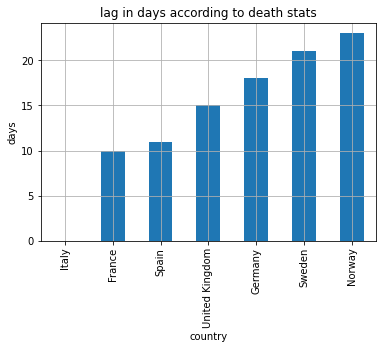

In [20]:
death_lags = death_trigger.apply(lambda x: x - death_trigger.min())
ax = death_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, title='lag in days according to death stats')
ax.set(ylabel='days')
plt.show()

In [21]:
death_offset_data = filter_by_trigger_date(data, 'deaths', threshold=threshold)
death_offset_data

,country,cases,deaths
date,,,
0 days,France,377.0,6.0
1 days,France,653.0,9.0
2 days,France,949.0,11.0
3 days,France,1126.0,19.0
4 days,France,1209.0,19.0
...,...,...,...
9 days,United Kingdom,2689.0,137.0
10 days,United Kingdom,3983.0,177.0
11 days,United Kingdom,5018.0,233.0


### lags between countries

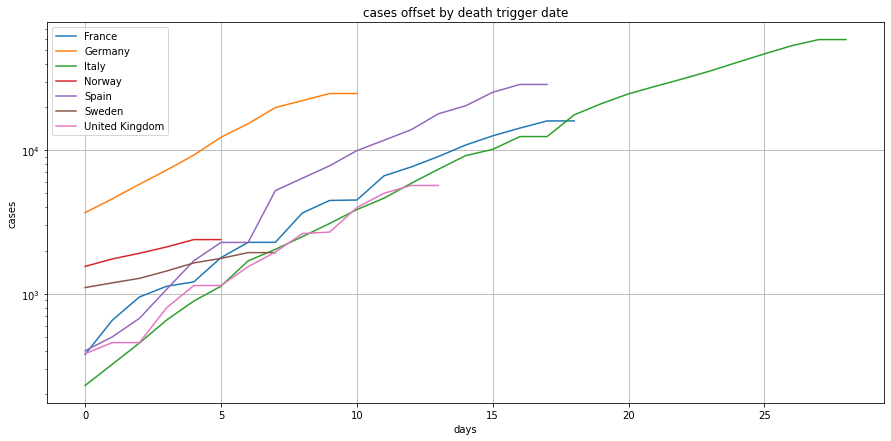

In [22]:
plot_by_country(death_offset_data, 'cases', title='cases offset by death trigger date', logy=True)

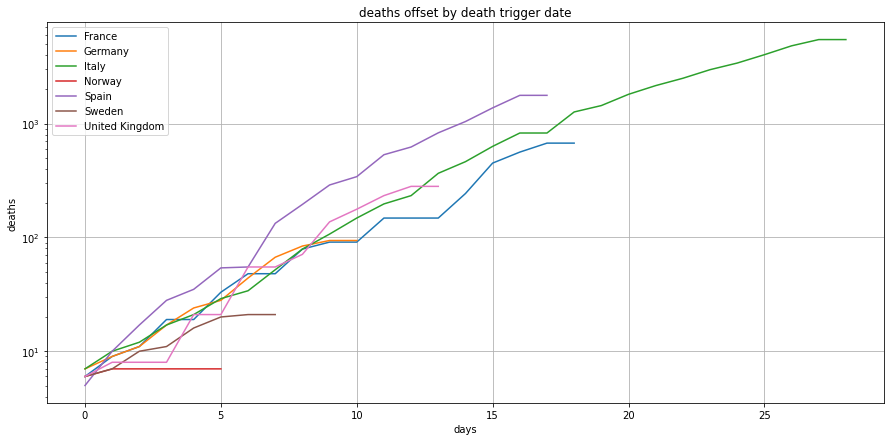

In [23]:
plot_by_country(death_offset_data, 'deaths', title='deaths offset by death trigger date', logy=True)

# Ideas:
- mitigate with population size, density